# Project 2 Numdiff

### Part 1: 1d stationary convection diffusion problem

Assume $\alpha \geq a_{0} > 0\text{, }c > 0$ and $\lVert \alpha \rVert_{L^{\infty}} + \lVert b \rVert_{L^{\infty}} + \lVert c \rVert_{L^{\infty}} + \lVert f \rVert_{L^{2}} \leq K \text{, } u(0) = u(1) = 0$

We have the model equation in form $-(\alpha u_{x})_{x} + (bu)_{x} + cu = f$. Now we multiply by the test equation $v(x)$ and perform the integral $\int_{0}^{1}dx$ on both sides:

$\int_{0}^{1}-(\alpha u_{x})_{x}v + (bu)_{x}v + cuv \text{ } dx = \int_{0}^{1}fv \text{ }dx$. We now perform integration by parts on the first two terms of the left hand side:

$ \int_{0}^{1}(\alpha u_{x})_{x}v = [\alpha u_{x}v]_{0}^{1} - \int_{0}^{1}\alpha u_{x}v_{x}\text{ }dx = -\int_{0}^{1}\alpha u_{x}v_{x}\text{ }dx$

### Part 2: Solving numerically

$A_{ij} = \int_{0}^{1} \alpha \phi^{'}_{i}\phi_{j}^{'} - b\phi_{i}\phi_{j}^{'} + c\phi_{i}\phi_{j} \text{dx}$

$F{j} = \int_{0}^{1}f\phi_{j} \text{dx}$

In [855]:
#Import libraries
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
import scipy
import math
import warnings
warnings.filterwarnings("ignore")
matplotlib.rc("ytick", labelsize = 8)
matplotlib.rc("xtick", labelsize = 8)

Triangulation of space: Choose nodes $x_i$ and elements $K_k=(x_{k-1},x_{k})$. Defining different grids to be used in project. Defining the global constants $\alpha,b,c = 1$ for the first part.

In [856]:
#Randomly selfmade gridpoints
Xk = np.array([0, 0.1, 0.3, 0,5, 0.6, 0.8, 0.9, 0.95, 0.97, 1])  # Nodes, elements K(i) = (x(i-1), x(i))
Hk = Xk[1:]-Xk[:-1]
Mk = len(Xk)

#Equispaced
Xeq = np.linspace(0,1,39)
Heq = Xeq[1:]-Xeq[:-1]

#Equispaced, fewer gridpoints (to be used in task 2e))
X_short = np.linspace(0,1,15)
H_short = X_short[1:] - X_short[:-1]
M_short = len(X_short)

#Closer near zero, fewer gridpoints (to be used in task 2e))
x1 = np.linspace(0,0.17,7)#7
x2 = np.linspace(0.2,1,8)#8
Xzero_short = np.concatenate((x1,x2))
Hzero_short = Xzero_short[1:] - Xzero_short[:-1]

#Tighter near x = 0
x2 = np.linspace(0.15,1,20)
x1 = np.linspace(0,0.10,19)
X_zero = np.concatenate((x1,x2))
H_zero = X_zero[1:]-X_zero[:-1]

#Tighter near center x = 0.5
x1 = np.linspace(0,0.35,5)
x2 = np.linspace(0.4,0.6,29)
x3 = np.linspace(0.65,1,5)
X_center = np.concatenate((x1,x2,x3))
H_center = X_center[1:]-X_center[:-1]

#Randomly distributed gridpoints
X_uni = np.random.uniform(0,1,21)
X_uni[0] = 0.5
X_uni = np.sort(X_uni)
X_uni[0] = 0
X_uni[-1] = 1
H_uni = X_uni[1:] - X_uni[:-1]
M_uni = len(X_uni)

Mi = len(Xeq)  # Number of nodes
alpha,b,c = 1,1,1 #Defining global constants
print("Equispaced: ", X_short)
print("\nMore near zero: ", Xzero_short)

Equispaced:  [0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]

More near zero:  [0.         0.02833333 0.05666667 0.085      0.11333333 0.14166667
 0.17       0.2        0.31428571 0.42857143 0.54285714 0.65714286
 0.77142857 0.88571429 1.        ]


Calculating vectors used in assembly of $A$ as defined in text.

In [857]:
#Calculate vectors as defined in text
def beta_vec(idx, h = Heq):
    """Main diagonal vector"""
    beta1 = (1/h[idx-1]) + (1/h[idx])
    beta2 = 0
    beta3 = (1/3)*(h[idx-1] + h[idx])
    return np.array([beta1,beta2,beta3])

def sigma_vec(idx, h = Heq):
    """Lower diagonal vector"""
    sig1 = -1/h[idx-1]
    sig2 = 0.5
    sig3 = h[idx-1]/6
    return np.array([sig1,sig2,sig3])

def gamma_vec(idx, h = Heq):
    """Upper diagonal vector"""
    gam1 = -1/h[idx]
    gam2 = -0.5
    gam3 = h[idx]/6
    return np.array([gam1,gam2,gam3])

### Testfunctions

In [858]:
def u1(x):
    return x*(1-x)
def f1(x):
    return 2*alpha + b*(1-2*x) + c*x*(1-x)
def du1(x):
    return 1-2*x
def ddu1(x):
    return -2*np.ones(len(x))

def u2(x):
    return np.sin(3*np.pi*x)
def f2(x):
    return 9*(np.pi**2)*np.sin(3*np.pi*x)*alpha + b*3*np.pi*np.cos(3*np.pi*x) + c*np.sin(3*np.pi*x)
def du2(x):
    return 3*np.pi*np.cos(3*np.pi*x)
def ddu2(x):
    return -9*np.pi**(2)*np.sin(3*np.pi*x)

def w1(x):
    left = x <= 0.5
    right = x > 0.5
    return 2*x*left + 2*(1-x)*right
def dw1(x, M = Mi):
    left = x <= 0.5
    right = x > 0.5
    return 2*left -2*right

def w2(x):
    return x - x**(2/3)
def f4(x):
    value = -alpha*(2/9)*x**(-4/3) + b*(1 - (2/3)*x**(-1/3)) + c*(x - x**(2/3))
    if math.isinf(-value[0]):
        value[0] = -10000
        return value
    else:
        return value
def dw2(x):
    return 1-(2/3)*x**(-1/3)

def f5(x):
    return x**(-1/4)

def L2_func(x = Xeq, f = f1):
    """Calculates L2_norm of inputfunction f in grid x."""
    return integrate.simpson(f(x)**2)**0.5

Different helping functions

In [859]:
def matprint(mat, fmt="g"):
    """prints matrix in a nicer format"""
    colums = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(colums[i])+fmt+"}").format(y), end="  ")
        print("")

def phi(x, i, nodes = Xeq):
    """Function phi(x) in the two intervals x in [x_i-1, x_i] and [x_i, x_i+1]as defined in text.
    Takes in point 'x' in array 'nodes' and index 'i'
        """
    if i == len(nodes) - 1:
        leq = x <= nodes[i]
        geq = x >= nodes[i-1]
        left = geq * leq
        return (x - nodes[i-1]) / (nodes[i] - nodes[i-1]) * left
    
    geq = x >= nodes[i-1]
    leq = x < nodes[i]
    left = geq * leq

    geq = x >= nodes[i]
    leq = x < nodes[i+1]
    right = geq * leq
    
    return (x - nodes[i-1]) / (nodes[i] - nodes[i-1]) * left + (nodes[i+1] - x) / (nodes[i+1] - nodes[i]) * right

def dphi(x, i, nodes = Xeq):
    """Function derivative of phi(x) as defined in text. See phi(x)."""
    if i == len(nodes) - 1:
        leq = x <= nodes[i]
        geq = x >= nodes[i-1]
        left = geq * leq
        return 1 / (nodes[i] - nodes[i-1]) * left
    
    geq = x >= nodes[i-1]
    leq = x < nodes[i]
    left = geq * leq

    geq = x >= nodes[i]
    leq = x < nodes[i+1]
    right = geq * leq

    return (1/(nodes[i] - nodes[i-1])) * left - (1/(nodes[i+1] - nodes[i])) * right

def F_vec(x = Xeq, idx = 1, h = Heq, f = f1):
    """Trapezoidal method on RHS of ODE. Expression derived by hand."""
    return 0.5*(f(x[idx-1])*(h[idx-1]+h[idx]))

def F_trapezoid(M = Mi, x = Xeq, h = Heq, f = f1):
    """Discretizarion of trapezoidal method.
    Returns vector f, trapezoidal evaluated at points in input array x."""
    f_vec = np.zeros(M-2)
    for j in range(1,M-1):
        f_vec[j-1] = F_vec(x, j, h, f)
    return f_vec

def F_RHS(x = 1, f = f1, i = 0, nodes = Xeq):
    """A function for the RHS for general f and phi."""
    return f(x)*phi(x,i,nodes)

def quad(M = Mi, x = Xeq, f = f1, nodes = Xeq):
    """Gaussian quadrature from scipy library."""
    RHS = np.zeros(M-2)
    for i in range(1,M-1):
        RHS[i-1] = integrate.quad(F_RHS, nodes[i-1], nodes[i+1], args = (f, i, nodes))[0]
    return RHS

def simp(M = Mi, x = Xeq, f = f1, nodes = Xeq):
    """Discretization of the Simpson method using the scipy library.
    Return vector RHS."""
    RHS = np.zeros(M-2)
    for i in range(1,M-1):
        RHS[i-1] = integrate.simpson(f(x)*phi(x,i,nodes), x)
    return RHS

def F_RHS_2d(x = Xeq, i = 0, nodes = Xeq):
    """RHS used specifically for task 2d"""
    RHS = alpha*dw1(x)*dphi(x,i,nodes) + b*dw1(x)*phi(x,i,nodes) + c*w1(x)*phi(x,i,nodes)
    return RHS

def quad_2d(M = Mi, x = Xeq, f = w1, nodes = Xeq):
    """Gauss. quad used for task 2d. See quad()."""
    RHS = np.zeros(M-2)
    for i in range(1, M-1):
        RHS[i-1] = integrate.quad(F_RHS_2d, nodes[i-1], nodes[i+1], args = (i, nodes))[0]
    return RHS

### Assembly $A$

In [860]:
def A_func(M = Mi, h = Heq):
    """Assembly of A as defined in text."""
    A = np.zeros((M-2,M-2))
    r = np.array([alpha,-b,c])
    for i in range(1,M-1):
        for j in range(1,M-1):
            if i == j:
                A[i-1][j-1] = r@beta_vec(i,h)
            if j == i+1:
                A[i-1][j-1] = r@gamma_vec(i,h)
            if j == i-1:
                A[i-1][j-1] = r@sigma_vec(i,h)
    return A

Printing the (inner) stiffness matrix $A$ in the case of $a, b, c = 1$. In this case an interesting case of randomly chosen gridpoints.

In [861]:
Ai = A_func(M = Mk, h = Hk)
matprint(Ai)

    15.1  -4.46667         0         0            0         0         0         0         0  
-5.46667   1.63333   3.78333         0            0         0         0         0         0  
       0   2.78333  -1.56667   1.13333            0         0         0         0         0  
       0         0  0.133333  0.172727  -0.00606061         0         0         0         0  
       0         0         0  -1.00606      3.37273  -4.46667         0         0         0  
       0         0         0         0     -5.46667      15.1  -9.48333         0         0  
       0         0         0         0            0  -10.4833     30.05  -19.4917         0  
       0         0         0         0            0         0  -20.4917   70.0233  -49.4967  
       0         0         0         0            0         0         0  -50.4967     83.35  


Solving the linear system $Ax = F$ where $F$ is calculated by use of Gaussian quadrature from the scipy library.
Calculating only for inner points since $U_{0} = U_{1} = 0$ is known. Solving for problems $u_{1} = x(1-x)$ and $u_{2} = sin(3\pi x)$. We use equidistant gridpoints in this case.

In [862]:
#Solving for u1
A = np.zeros((Mi,Mi))
U1 = np.zeros(Mi)
fi_u1 = quad(f = f1)
Ai = A_func()
Ui_u1 = np.linalg.solve(Ai,fi_u1)
U1[1:-1] = Ui_u1

#Solving for u2
U2 = np.zeros(Mi)
fi_u2 = quad(f = f2)
Ui_u2 = np.linalg.solve(Ai,fi_u2)
U2[1:-1] = Ui_u2

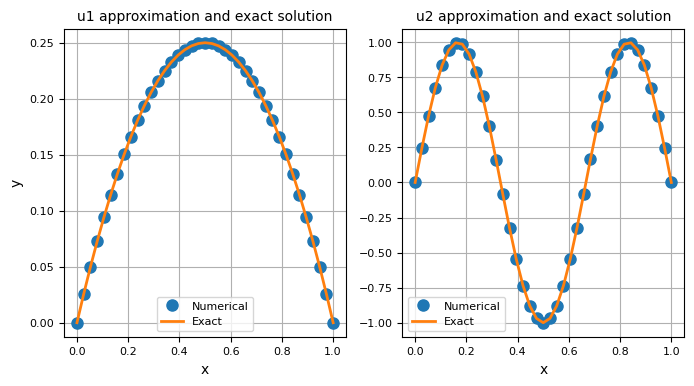

In [863]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle(r"Solutions to $u_{1}$ and $u_{2}$ with equispaced gridpoints", fontsize = 13)
ax1.plot(Xeq,U1,'o', Xeq,u1(Xeq))
ax1.legend(['Numerical','Exact'], prop={'size': 8})
ax1.set_title("u1 approximation and exact solution", size = 10)
ax1.set_xlabel('x', size = 10)
ax1.set_ylabel("y", size = 10)

ax2.plot(Xeq,U2,'o',Xeq,u2(Xeq))
ax2.legend(['Numerical','Exact'], prop={'size': 8})
ax2.set_title("u2 approximation and exact solution", size = 10)
ax2.set_xlabel('x', size = 10)
plt.show()

Implementing solver to be used in convergence plots.

In [864]:
def supersolver_H1(M = Mi, x = Xeq, h = Heq, func = F_trapezoid, f = f1, nodes = Xeq):
    """To be used in convergence plot. Returns uh and duh from input u and f."""
    Ai = A_func(len(nodes), h)
    fi = func(len(nodes), x, f, nodes) #to be used for simp
    Ui = np.linalg.solve(Ai, fi) #coeffs
    U = np.zeros(len(nodes))
    U[1:-1] = Ui
    uh = np.zeros(M)
    d_uh = np.zeros(M)
    for i in range(len(nodes)):
        uh += U[i]*phi(x,i,nodes)
        d_uh += U[i]*dphi(x,i,nodes)
    return uh,d_uh

Function to test the convergence rate. Also defining error bound given by $\|u-u_{h}\|_{H^{1}} \leq \frac{M}{\alpha}\|u-I_{h}u\|_{H^{1}} \leq \frac{2M}{\alpha}\|u_{xx}\|_{L^{2}(0,1)}h$ to be used in task $2b$. Here $M = K \geq \|\alpha\|_{\infty} + \|b\|_{\infty} + \|c\|_{\infty} + \|f\|_{L_{2}}$ and $\alpha = \text{min\{}\frac{\alpha}{2}, \frac{\|b\|^{2}}{2\alpha}\} = \frac{\alpha}{2}$ in this case. NB: Don't be confused by the notation, here there are 2 different $\alpha$. We denote the $\alpha$ in the bound as $\alpha_{1}$. Solver uses Simpsons method.

In [865]:
def converge_H1(u_exact, du_exact, solver = supersolver_H1, func = simp, f = f1, eBound = False):
    alpha1 = alpha/2 #Alpha from boundedness
    K = 5
    Hconv = np.zeros(K)
    Econv_L2 = np.zeros(K)
    Econv_H1 = np.zeros(K)
    u1bound = np.zeros(K)
    u2bound = np.zeros(K)
    M = 10
    x = np.linspace(0,1,1000)
    M1 = alpha + np.abs(b) + c + L2_func(f1(x))
    M2 = alpha + np.abs(b) + c + L2_func(f2(x))
    for k in range(K):
        nodes = np.linspace(0,1,M)
        h = nodes[1:] - nodes[:-1]
        Uh, dUh = solver(len(x), x, h, func, f, nodes)
        norm_L2 = integrate.simpson((u_exact(x[1:-1]) - Uh[1:-1])**2) #squared of norm(u-uh) in L2
        ddu1_norm = integrate.simpson(ddu1(x[1:-1])**2)**0.5
        ddu2_norm = integrate.simpson(ddu1(x[1:-1])**2)**0.5
        norm_L2_d = integrate.simpson((du_exact(x[1:-1]) - dUh[1:-1])**2)
        Error_H1 = (norm_L2 + norm_L2_d)**0.5 #norm(u-uh) in H1
        Error_L2 = norm_L2**0.5
        Hconv[k] = (nodes[1]-nodes[0])
        u1bound[k] = ddu1_norm*M1*2*h[0]/alpha1
        u2bound[k] = ddu2_norm*M2*2*h[0]/alpha1
        Econv_L2[k] = np.max(np.abs(Error_L2))
        Econv_H1[k] = np.max(np.abs(Error_H1))
        M = M*2
    order_L2 = np.polyfit(np.log(Hconv),np.log(Econv_L2),1)[0]
    order_H1 = np.polyfit(np.log(Hconv),np.log(Econv_H1),1)[0]
    if eBound == True:
        return Hconv, Econv_L2, order_L2, Econv_H1, order_H1, u1bound, u2bound
    return Hconv, Econv_L2, order_L2, Econv_H1, order_H1

In [866]:
hu1,eu1_L2,ou1_L2,eu1_H1,ou1_H1,u1bnd,dummy1 = converge_H1(u1,du1, supersolver_H1, func = simp, f = f1, eBound = True)
hu2,eu2_L2,ou2_L2,eu2_H1,ou2_H1,u2bnd,dummy2 = converge_H1(u2,du2, supersolver_H1, func = simp, f = f2, eBound = True)

Plotting solutions to $u_{1}$ and $u_{2}$ with their analytic solutions. Also plotting their convergence in $H^{1}$ and $L^{2}$ and in addition an error bound in $H^{1}$.

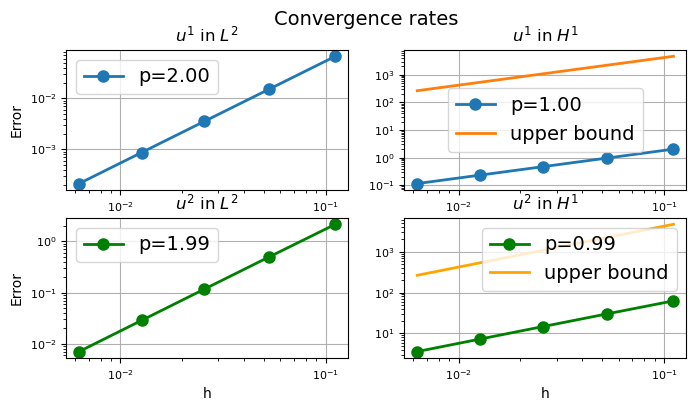

In [867]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = (8,4))
fig.suptitle("Convergence rates", fontsize = 14)
ax1.loglog(hu1,eu1_L2,'o-', label='p={:.2f}'.format(ou1_L2))
ax1.set_title(f"$u^{1}$ in $L^{2}$", size = 12)
ax1.set_xlabel('h')
ax1.set_ylabel('Error', size = 10)
ax1.legend()

ax2.loglog(hu1,eu1_H1,'o-', label='p={:.2f}'.format(ou1_H1))
ax2.loglog(hu1,u1bnd, label = "upper bound")
ax2.set_title(f"$u^{1}$ in $H^{1}$", size = 12)
ax2.set_xlabel('h', size = 10)
ax2.legend()

ax3.loglog(hu2,eu2_L2,'o-', label='p={:.2f}'.format(ou2_L2), color = "green")
ax3.set_title(f"$u^{2}$ in $L^{2}$", size = 12)
ax3.set_xlabel('h', size = 10)
ax3.set_ylabel('Error', size = 10)
ax3.legend()

ax4.loglog(hu2,eu2_H1,'o-', label='p={:.2f}'.format(ou2_H1), color = "green")
ax4.loglog(hu1,u2bnd, label="upper bound", color = "orange")
ax4.set_title(f"$u^{2}$ in $H^{1}$", size = 12)
ax4.set_xlabel('h', size = 10)
ax4.legend()
plt.show()

Solving problem $w_{1} = x-|x|^{\frac{2}{3}}$ with Gaussian quardature.

In [868]:
Ai = A_func(M = M_uni, h = H_uni)
fi = quad_2d(M = M_uni, x = X_uni, nodes = X_uni)
U = np.zeros(M_uni)
Ui = np.linalg.solve(Ai,fi)
U[1:-1] = Ui

Plotting solution of $w_{1}$ and its analytic solution with random gridpoints.

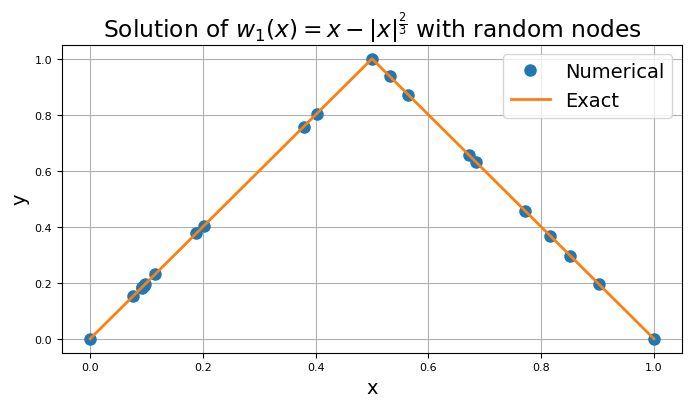

In [869]:
plt.plot(X_uni,U,'o',X_uni,w1(X_uni))
plt.legend(['Numerical','Exact'])
plt.title(r"Solution of $w_{1}(x) = x - |x|^{\frac{2}{3}}$ with random nodes")
plt.ylabel("y")
plt.xlabel('x')
plt.show()

Solving problem $w_{2}$ as defined in text for equidistant grids and for grids with closer spacing near zero.

In [870]:
#Equidistant
Ai = A_func(M = Mi, h = Heq)
fi_eq = simp(M = Mi, x = Xeq, f = f4)
U_eq = np.zeros(Mi)
Ui_eq = np.linalg.solve(Ai,fi_eq)
U_eq[1:-1] = Ui_eq

#Closer near zero
Ai = A_func(Mi, h = H_zero)
fi_zero = simp(M = Mi, x = X_zero, f = f4, nodes = X_zero)
U_zero = np.zeros(Mi)
Ui_zero = np.linalg.solve(Ai,fi_zero)
U_zero[1:-1] = Ui_zero

Plotting the result.

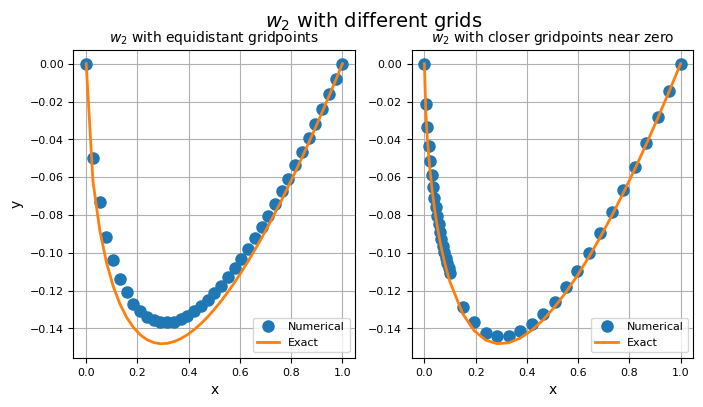

In [871]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f"$w_{2}$ with different grids", fontsize = 14)
ax1.plot(Xeq,U_eq,'o', Xeq,w2(Xeq))
ax1.legend(['Numerical','Exact'], prop={'size': 8})
ax1.set_title(f"$w_{2}$ with equidistant gridpoints", size = 10)
ax1.set_ylabel("y", size = 10)
ax1.set_xlabel('x', size = 10)

ax2.plot(X_zero,U_zero,'o',X_zero,w2(X_zero))
ax2.legend(['Numerical','Exact'], prop={'size': 8})
ax2.set_title(f"$w_{2}$ with closer gridpoints near zero", size = 10)
ax2.set_xlabel('x', size = 10)
plt.show()

Here we just redefine function **converge_H1()** to use it on $w_{1}$ and $w_{2}$. It doesn't compute error bound, so it should run faster.

In [872]:
def converge_H1(u_exact, du_exact, solver = supersolver_H1, func = simp, f = f1):
    K = 5
    Hconv = np.zeros(K)
    Econv_L2 = np.zeros(K)
    Econv_H1 = np.zeros(K)
    M = 10
    x = np.linspace(0,1,10000)
    for k in range(K):
        nodes = np.linspace(0,1,M)
        h = nodes[1:] - nodes[:-1]
        Uh, dUh = solver(len(x), x, h, func, f, nodes)
        norm_L2 = integrate.simpson((u_exact(x[1:-1]) - Uh[1:-1])**2) #squared of norm(u-uh) in L2
        norm_L2_d = integrate.simpson((du_exact(x[1:-1]) - dUh[1:-1])**2)
        Error_H1 = (norm_L2 + norm_L2_d)**0.5 #norm(u-uh) in H1
        Error_L2 = norm_L2**0.5
        Hconv[k] = (nodes[1]-nodes[0])
        Econv_L2[k] = np.max(np.abs(Error_L2))
        Econv_H1[k] = np.max(np.abs(Error_H1))
        M = M*2
    order_L2 = np.polyfit(np.log(Hconv),np.log(Econv_L2),1)[0]
    order_H1 = np.polyfit(np.log(Hconv),np.log(Econv_H1),1)[0]
    return Hconv, Econv_L2, order_L2, Econv_H1, order_H1

In [873]:
hw1,ew1_L2,ow1_L2,ew1_H1,ow1_H1 = converge_H1(w1,dw1, supersolver_H1, func = quad_2d, f = w1)
hw2,ew2_L2,ow2_L2,ew2_H1,ow2_H1 = converge_H1(w2,dw2, supersolver_H1, func = simp, f = f4)

Plotting the convergence rates. Keep in mind the result will sligthly depend on how many gridpoints and how well refined the grid is.

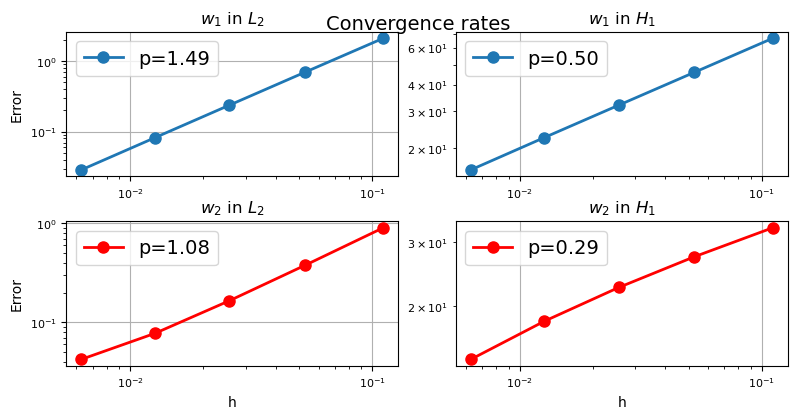

In [874]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
fig.tight_layout()
fig.suptitle("Convergence rates", fontsize = 14)
ax1.loglog(hw1,ew1_L2,'o-', label='p={:.2f}'.format(ow1_L2))
ax1.set_title(f"$w_{1}$ in $L_{2}$", size = 12)
ax1.set_ylabel('Error', size = 10)
ax1.legend()

ax2.loglog(hw1,ew1_H1,'o-', label='p={:.2f}'.format(ow1_H1))
ax2.set_title(f"$w_{1}$ in $H_{1}$", size = 12)
ax2.legend()

ax3.loglog(hw2,ew2_L2,'o-', label='p={:.2f}'.format(ow2_L2), color = "red")
ax3.set_title(f"$w_{2}$ in $L_{2}$", size = 12)
ax3.set_xlabel('h', size = 10)
ax3.set_ylabel('Error', size = 10)
ax3.legend()

ax4.loglog(hw2,ew2_H1,'o-', label='p={:.2f}'.format(ow2_H1), color = "red")
ax4.set_title(f"$w_{2}$ in $H_{1}$", size = 12)
ax4.set_xlabel('h', size = 10)
ax4.legend()
plt.show()

Solving the problem of RHS function $f(x) = x^{-\frac{1}{4}}$. Keep in mind we don't have an analytic solution, so the "analytic" solution $u_{5}$ will just be a very refined approximation, namely one with 1000 equispaced gridpoints.

In [875]:
def Error_2e(M = Mi, nodes = Xeq, h = Heq):
    """Returns 'u_exact' and approximation. Approximation will be either
    with equispaced points or more points near zero, depending on input."""
    x = np.linspace(0,1,1000)
    M_exact = len(x)
    H_exact = x[1:]-x[:-1]
    Ai = A_func(M = M_exact, h = H_exact)
    fi = quad(M = M_exact, x = x, f = f5, nodes = x)
    u_exact = np.zeros(M_exact)
    Ui = np.linalg.solve(Ai,fi)
    u_exact[1:-1] = Ui

    Ai_apx = A_func(M = M, h = h)
    fi_apx = quad(M = M, x = nodes, f = f5, nodes = nodes)
    U_apx = np.zeros(M)
    Ui_apx = np.linalg.solve(Ai_apx,fi_apx)
    U_apx[1:-1] = Ui_apx

    return x, nodes, u_exact, U_apx 

We define two solutions with the same amount of nodes (15). One with equispaced points and one with more points near zero.

In [876]:
alpha,b,c = 1,-5, 14 #Redefining global variables for 2e)
x, x_node_short, u5, u_short = Error_2e(M = M_short, nodes = X_short, h = H_short)
x, x_node_zero, u5, u_zero = Error_2e(M = M_short, nodes = Xzero_short, h = Hzero_short)

We plot the two solutions to the "analytic" function $u_{5}$.

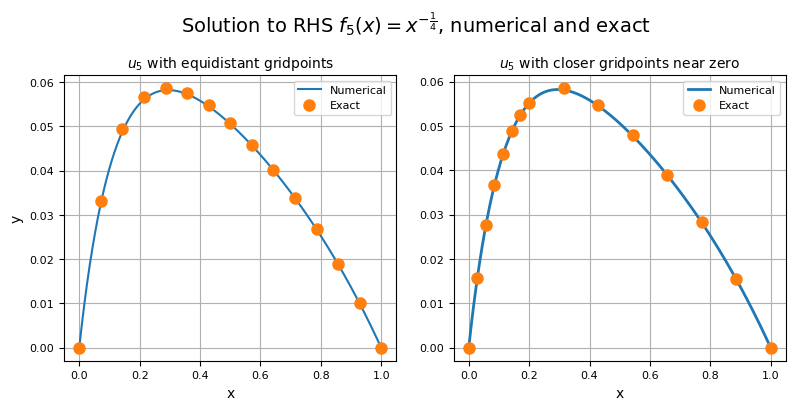

In [877]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(r"Solution to RHS $f_{5}(x) = x^{-\frac{1}{4}}$, numerical and exact", fontsize = 14)
fig.tight_layout()
ax1.plot(x,u5,linewidth = 1.5)
ax1.plot(x_node_short,u_short,'o', linewidth = 0.5)
ax1.legend(['Numerical','Exact'], prop={'size': 8})
ax1.set_title(f"$u_{5}$ with equidistant gridpoints", size = 10)
ax1.set_ylabel("y", size = 10)
ax1.set_xlabel('x', size = 10)

ax2.plot(x,u5)
ax2.plot(x_node_zero,u_zero, 'o', linewidth = 0.5)
ax2.legend(['Numerical','Exact'], prop={'size': 8})
ax2.set_title(f"$u_{5}$ with closer gridpoints near zero", size = 10)
ax2.set_xlabel('x', size = 10)
plt.show()

We test the error in $L_{2}$ for the two different cases. The error computed is $\|u-u_{h}\|_{L^{2}}$. The goal is to show that gridpoints closer to zero gives a better approximation even for the same amount of points.

In [878]:
x = np.linspace(0,1,1000)
uh_eq = np.zeros(len(x))
uh_zero = np.zeros(len(x))

for i in range(M_short):
    uh_eq += u_short[i]*phi(x,i,X_short)
    uh_zero += u_zero[i]*phi(x,i,Xzero_short)

Error_eq = (integrate.simpson((u5 - uh_eq)**2,x))**0.5
Error_zero = (integrate.simpson((u5 - uh_zero)**2,x))**0.5
print("Error for equidistant: ", Error_eq)
print("\nError for closer near zero: ", Error_zero)

Error for equidistant:  0.0005232592796499337

Error for closer near zero:  0.00027191257863051733


As expected, the error near zero is smaller.